In [107]:
import numpy as np
from tqdm import tqdm
import numpy as np
import pandas as pd
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kmeans import kmeans_centroids
from tqdm import tqdm
from sklearn.svm import SVC
from SVM import OVO_test, OVO_train
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import kernels
from sklearn.model_selection import GridSearchCV

def plot_image(image, ax):
    im = np.zeros_like(image)
    for i in range(3):
        channel_min = np.min(image[:,:,i], keepdims=True)
        channel_max = np.max(image[:,:,i], keepdims=True)
        im[:,:,i] = (image[:,:,i] - channel_min) / (channel_max - channel_min)
    ax.imshow(im)

In [108]:
Xtr = pd.read_csv('data/Xtr.csv',header=None,sep=',',usecols=range(3072))
Xte = pd.read_csv('data/Xte.csv',header=None,sep=',',usecols=range(3072))
Ytr_ = pd.read_csv('data/Ytr.csv')#, index_col = None, header = None)

In [109]:
Xtr = np.array(Xtr).reshape(5000, 3,32, 32).swapaxes(1,2).swapaxes(2,3)
Xte = np.array(Xte).reshape(2000, 3,32, 32).swapaxes(1,2).swapaxes(2,3)
Ytr = np.array(Ytr_['Prediction'])
X_tot = np.vstack([Xtr, Xte]) #Entire dataset used for feature extraction

# Feature learning

In [110]:
def extract_random_patch(image, rf_size):
    corner = np.random.randint(32 - rf_size, size=2)
    i,j = corner[0], corner[1]
    patch = image[i:i+rf_size, j:j+rf_size, :]
    patch = patch - np.mean(patch)
    patch/=(np.std(patch)+1)
    return patch

def extract_patches(dataset, num_patches, rf_size):
    patches = np.zeros((num_patches, rf_size*rf_size*3))
    for i in tqdm(range(num_patches)):
        img_idx = i%len(dataset)
        patch = extract_random_patch(dataset[img_idx], rf_size)
        patches[i] = patch.reshape(-1)
    return patches 

#def cluster_patches(patches, k):
#    clust = Kmeans(m = k)
#    clust.fit(patches, n_iter = 50, verbose=False)
#    return clust.mu, clust.assignments

def cluster_patches(patches, k):
    clust = KMeans(n_clusters = k, max_iter = 50, n_init = 5, verbose= True)
    clust.fit(patches)
    return clust.cluster_centers_, clust.labels_

def whiten_patches(patches):
    
    C = np.cov(patches, rowvar=False)  
    M = np.mean(patches, axis=0)
    d, V = np.linalg.eigh(C)
    D = np.diag(np.sqrt(1. / (d + 0.1)))
    P = np.matmul(np.matmul(V, D), V.T)
    feats = np.matmul(patches - M, P)

    return feats, M, P 

In [111]:
##Extract
patches = extract_patches(X_tot, 200000, 6)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200000/200000 [00:09<00:00, 21588.61it/s]


In [112]:
##Whiten
patches, M, P = whiten_patches(patches)

In [114]:
##Cluster
#centroids, labels = cluster_patches(patches, 100)
centroids = kmeans_centroids(patches, num_centroids = 400, n_iter = 50)

  0%|                                                                                                                                                                                          | 0/50 [00:00<?, ?it/s]/Users/jeanelkhoury/Desktop/MVA/kernel/KernelMethodsMVA/kmeans.py:27: RuntimeWarning: invalid value encountered in true_divide
  centroids = Sum / cluster_sizes
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:43<00:00,  1.15it/s]


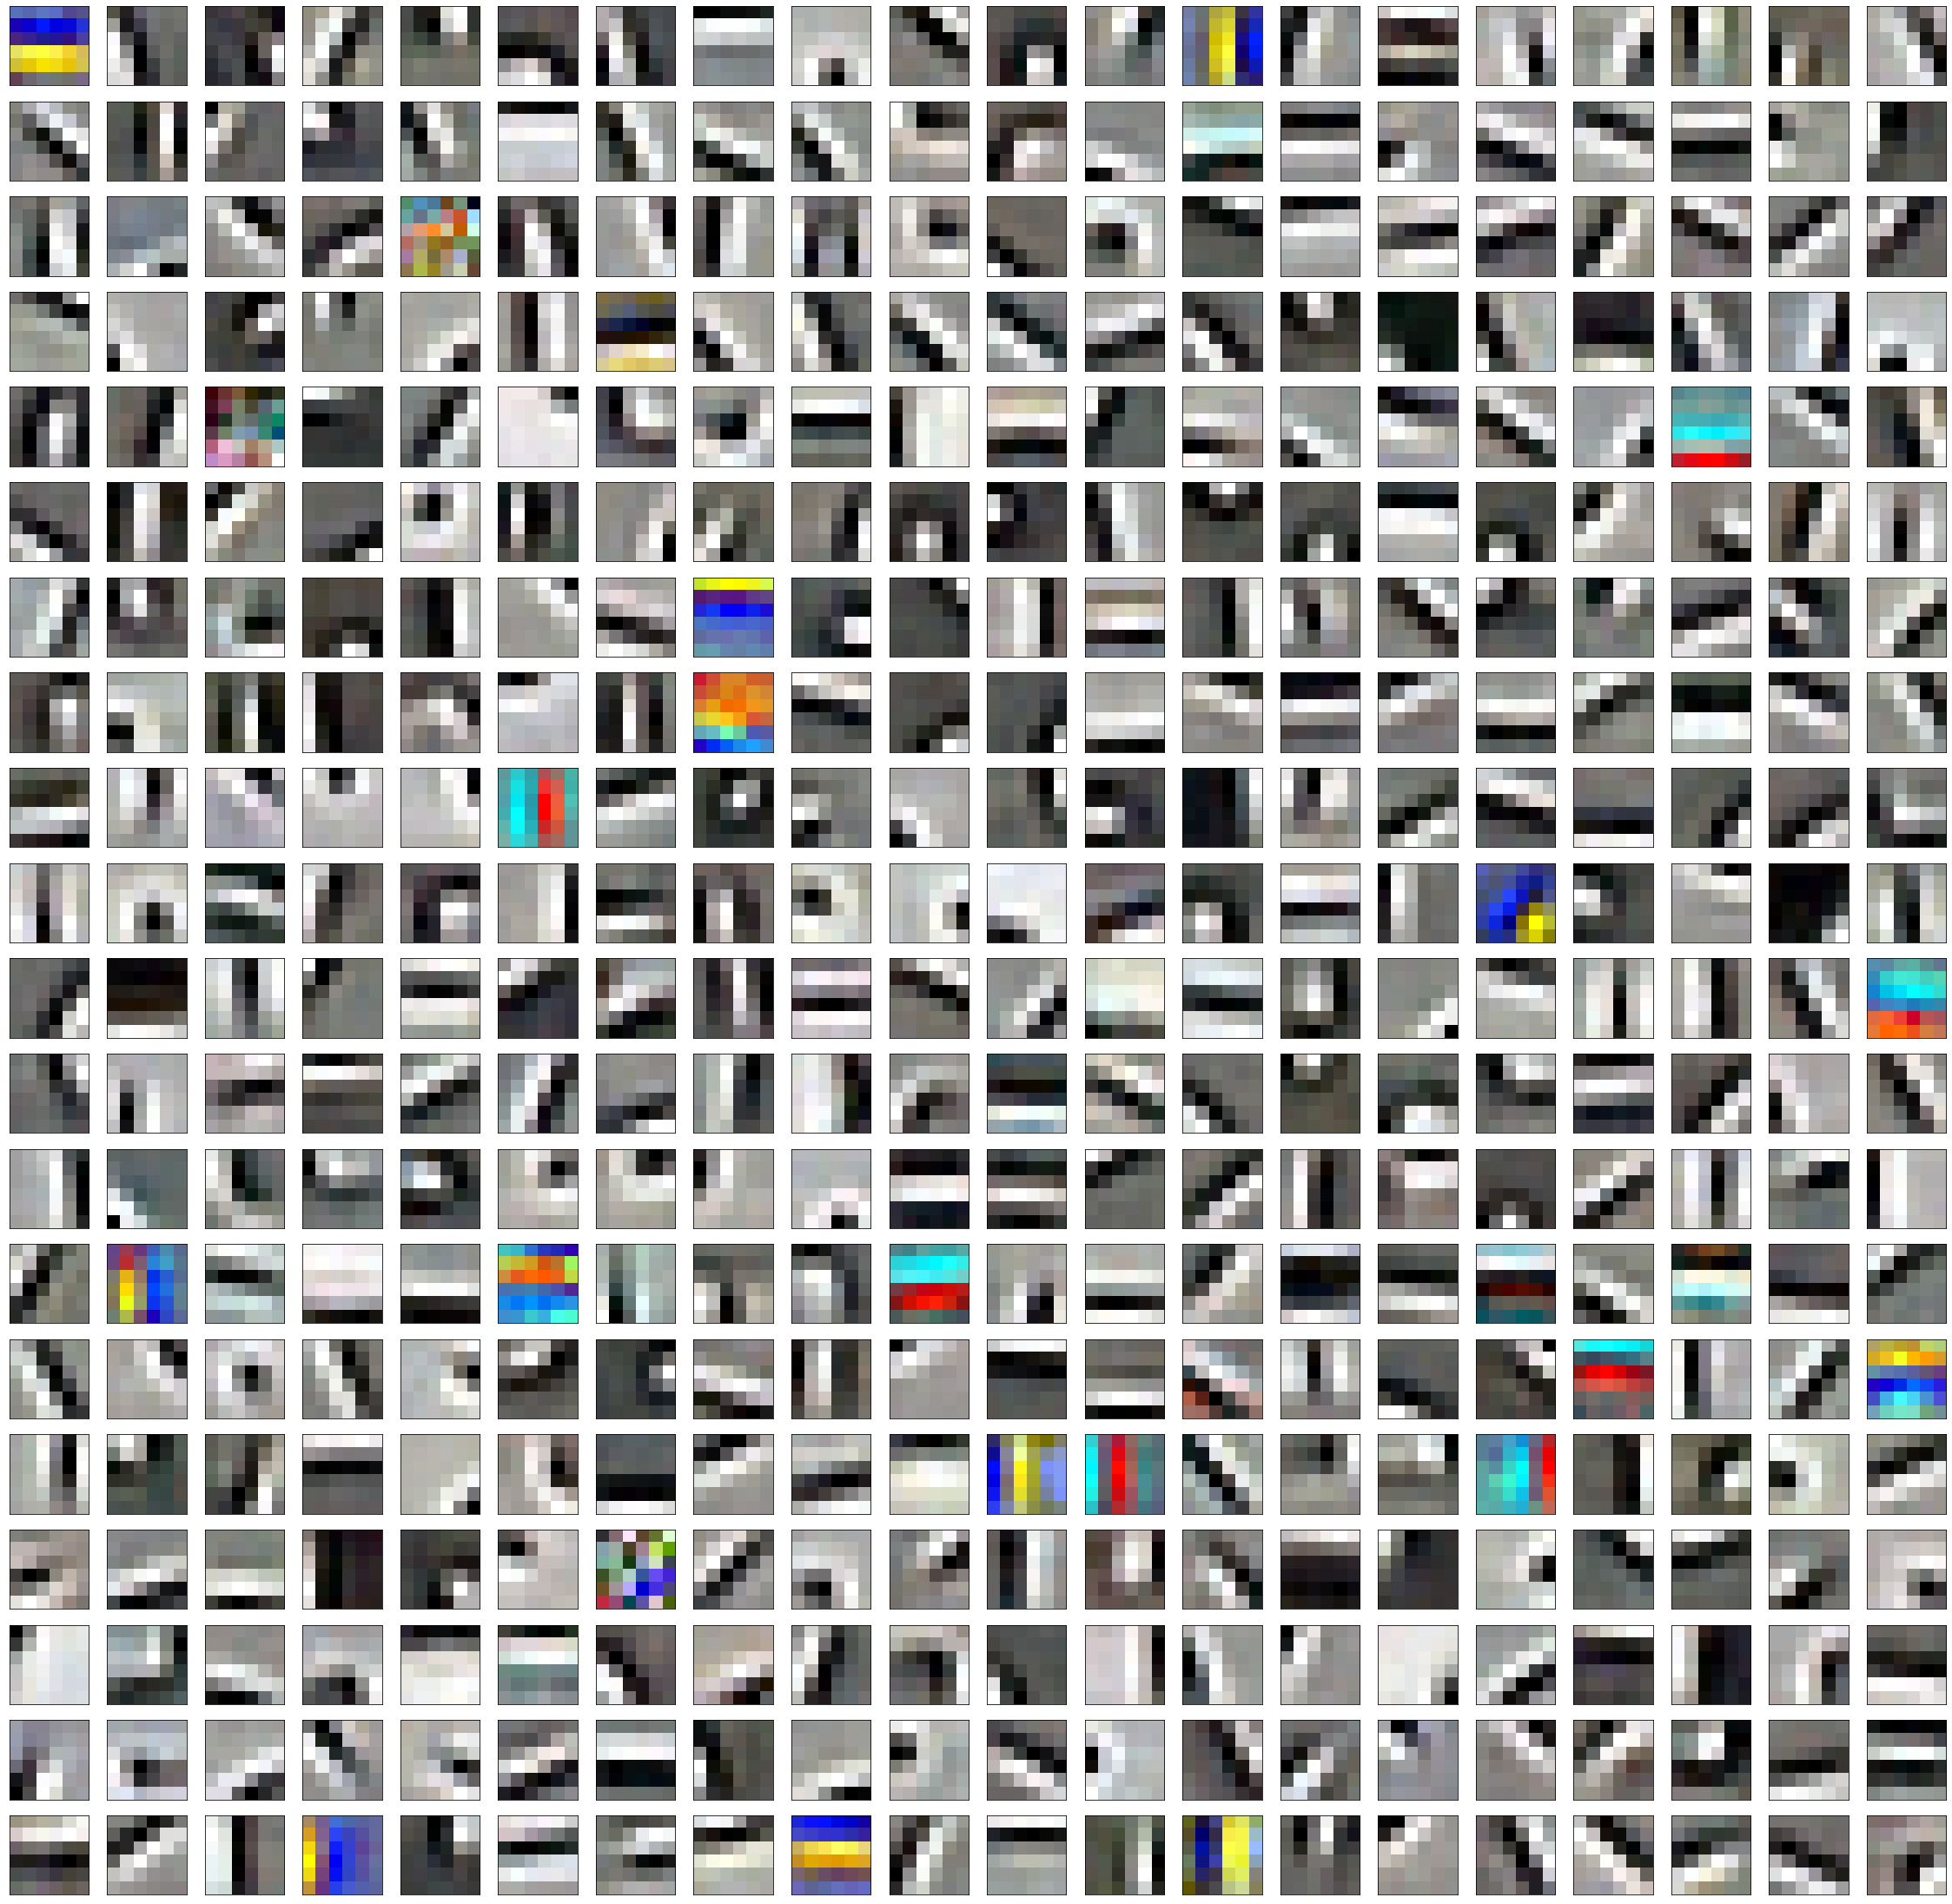

In [119]:
##Plot the centroids

fig, ax = plt.subplots(20,20, figsize = (40,40))
idx = 0
for i in range(20):
    for j in range(20):
        plot_image(centroids[idx].reshape(6, 6, 3), ax[i,j])
        ax[i,j].axes.xaxis.set_visible(False)
        ax[i,j].axes.yaxis.set_visible(False)
        idx+=1

# Feature extraction

In [115]:
def get_quarters(img):
    img_size = img.shape[0]
    half_size = img_size//2
    q1 = img[:half_size, :half_size,:]
    q2 = img[half_size:, :half_size,:]
    q3 = img[:half_size, half_size:,:]
    q4 = img[half_size:, half_size:,:]
    return [q1, q2, q3, q4]

def compute_features_patch(patch, centroids):
    k = len(centroids)
    z = np.zeros(k)
    for i, centroid in enumerate(centroids):
        z[i] = np.linalg.norm(patch - centroid)
    f =  np.maximum(np.zeros(k), np.mean(z)*np.ones(k) - z)
    return f

def compute_features_img(img, centroids, stride, patch_size):
    k = len(centroids)
    img_feat = np.zeros(k)
    img_size = img.shape[0]
    i = 0
    while i+patch_size < img_size:
        j = 0
        while j+patch_size < img_size:
            patch = img[i:i+patch_size, j:j+patch_size,:]
            patch = patch.reshape(-1)
            
            patch = (patch - patch.mean())/(patch.std()+1) #normalize
            patch = np.matmul(patch - M, P) #whiten
            j+=stride
            f = compute_features_patch(patch, centroids)
            img_feat += f
            #print(i,j)
        i+=stride
    return img_feat

def compute_features(dataset, centroids, stride, patch_size, M, P):

    X = []    
    for idx in tqdm(range(len(dataset))):
        img = dataset[idx]
        quart = get_quarters(img)
        f = []
        for i in range(4):
            quarter_feats = compute_features_img(quart[i], centroids, stride, patch_size)
            f.append(quarter_feats) #k features per quarter
        #print(f.shape)
        X.append(f)
    X = np.array(X)
    X = X.reshape(len(X), -1)
    return X

def post_processing(X):
    X -= X.mean(axis=0, keepdims=True)
    X /= (0.01 + np.std(X, axis=0))
    #X = np.hstack([X, np.ones((len(X), 1))])
    return X


In [122]:
X_train = np.load('data/X_train.npy')
X_test= np.load('data/X_test.npy')

X_train = post_processing(X_train)
X_test = post_processing(X_test)

In [123]:
X_tr, X_te, y_tr = X_train, X_test, Ytr

In [124]:
X_tr.shape[1]*X_tr.var()

1582.8299716660608

In [ ]:
dic = OVO_train(X_tr, y_tr, sigma = 60, C = 10, ker = kernels.LaplacianRBFKernel)

In [73]:
pred = OVO_test(X_te, dic)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:45<00:00,  3.81it/s]


In [125]:
classifier = SVC(C=30, decision_function_shape='ovo', gamma = 5e-5, tol = 0.01, verbose=True)
#gammas = [i*1e-5 for i in range(2, 7)]
#param_dict = {'gamma':gammas, 'C':[10, 20, 30]}#, 20, 30, 40]}
#cv = GridSearchCV(classifier, param_dict)
#cv.fit(X_tr, y_tr)
classifier.fit(X_tr, y_tr)

[LibSVM]*.*
optimization finished, #iter = 1398
obj = -6047.821924, rho = -2.214657
nSV = 370, nBSV = 205
.*
optimization finished, #iter = 1976
obj = -8965.369599, rho = -4.445434
nSV = 496, nBSV = 301
*.*
optimization finished, #iter = 1543
obj = -5776.297061, rho = -4.447721
nSV = 354, nBSV = 187
*.*
optimization finished, #iter = 1567
obj = -6415.652386, rho = -7.652710
nSV = 375, nBSV = 205
*.*
optimization finished, #iter = 1173
obj = -4758.836664, rho = -5.808948
nSV = 301, nBSV = 153
*.*
optimization finished, #iter = 1209
obj = -4681.482344, rho = -7.939732
nSV = 290, nBSV = 153
*.*
optimization finished, #iter = 1337
obj = -5359.100128, rho = -6.980880
nSV = 322, nBSV = 172
.*.*
optimization finished, #iter = 2148
obj = -11211.412082, rho = 0.149219
nSV = 585, nBSV = 403
*.*
optimization finished, #iter = 1456
obj = -6521.655193, rho = -4.161741
nSV = 375, nBSV = 208
*.*
optimization finished, #iter = 1428
obj = -4539.383582, rho = 0.262855
nSV = 314, nBSV = 144
*.*
optimizat

SVC(C=30, decision_function_shape='ovo', gamma=5e-05, tol=0.01, verbose=True)

In [126]:
pred = classifier.predict(X_test)

In [127]:
np.save("pred_cv.npy", pred)

In [104]:
accuracy_score(pred, y_te)

0.532

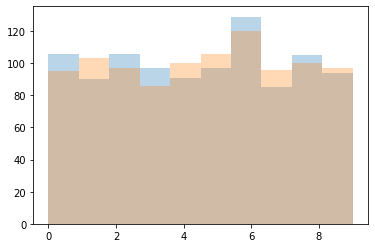

In [106]:
plt.hist(pred, alpha=0.3)
plt.hist(y_te, alpha=0.3)
plt.show()